# Choosing your CRM

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pywaterflood import CRM

`pywaterflood` offers several options for capacitance resistance modeling. Depending on the amount and quality of the data, the best model will change.

## Data exploration

In order to decide which model, first look at the size and quantity of the data.

In [2]:
gh_url = "https://raw.githubusercontent.com/frank1010111/pywaterflood/master/testing/data/"
prod = pd.read_csv(gh_url + "production.csv", header=None)
inj = pd.read_csv(gh_url + "injection.csv", header=None)
time = pd.read_csv(gh_url + "time.csv", header=None)

Because this is test data, and test data can be anything, it's in reservoir barrels! Nice! It is a tiny field with 4 producers, 5 producers, and 300 months of production history.

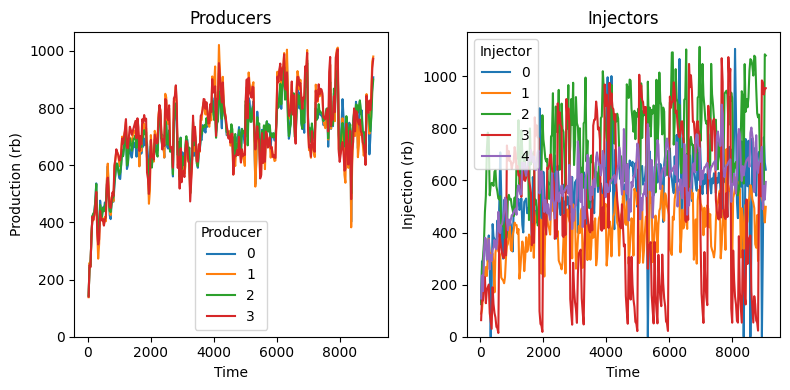

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
prod.join(time.rename(columns={0: "Time"})).set_index("Time").rename_axis(columns="Producer").plot(
    ax=ax1
)
inj.join(time.rename(columns={0: "Time"})).set_index("Time").rename_axis(columns="Injector").plot(
    ax=ax2
)
ax1.set(ylim=(0, None), ylabel="Production (rb)", title="Producers")
ax2.set(ylim=(0, None), ylabel="Injection (rb)", title="Injectors")
fig.tight_layout()

A few things jump out:
1. Clearly we're at the start of the waterflood. Production starts very low and increases, and injection starts with injector 1 going at full throttle, then within the first year the others start catching up. This means that the CRM does not have to include primary production.
2. The injectors have high variance in injectivity, and they don't all fluctuate in phase. This means CRM might work well! Yay!
3. There is enough data here for per-pair taus.

One more thing to check: the material balance. Why does that matter? 
1. If the production is much more than the injection, you might have an aquifer and want to add a pseudo-well.
2. If the production is much less or about the same, you can apply stronger constraints to the gain constraints.

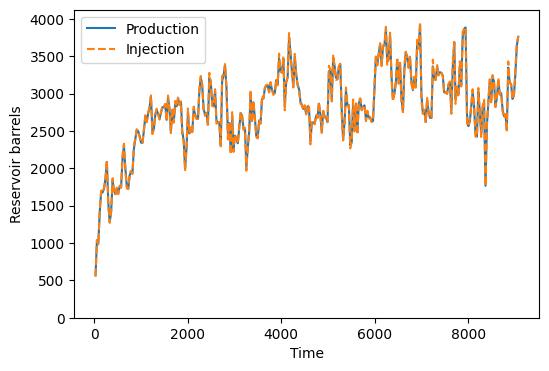

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(time, prod.sum(axis=1), label="Production")
ax.plot(time, inj.sum(axis=1), "--", label="Injection")
ax.set(xlabel="Time", ylabel="Reservoir barrels", ylim=(0, None))
ax.legend()

The production and injection are exactly in sync! This is very rare in real datasets, but we'll allow it. 

## Testing out CRMs

Now, let's try out our first CRM

In [5]:
crm = CRM(primary=False, tau_selection="per-pair", constraints="up-to one")
crm.fit(prod.values, inj.values, time.values[:, 0])
q_hat = crm.predict()

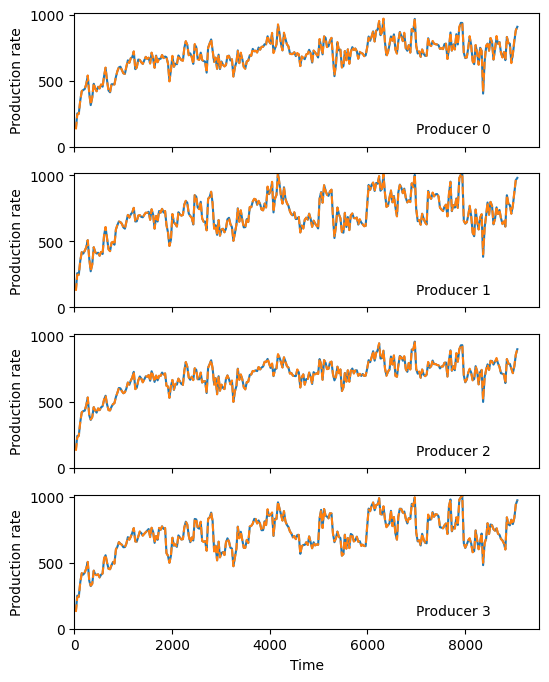

In [6]:
fig, axes = plt.subplots(len(prod.columns), figsize=(6, 8), sharex=True, sharey=True)
for i, p in enumerate(prod):
    axes[i].plot(time, prod[p], label="Production")
    axes[i].plot(time, q_hat[:, i], ls="--", label="Prediction")
    axes[i].set(xlim=(0, None), ylim=(0, None), ylabel="Production rate")
    axes[i].annotate(f"Producer {p}", xy=(7000, 100))
axes[i].set(xlabel="Time");

That's a nice set of fits. Now there's no sense in not trying out other models, [Wanderley et al](https://www.mdpi.com/1996-1073/11/12/3368) catalog several other CRM models:

<img src="https://www.mdpi.com/energies/energies-11-03368/article_deploy/html/images/energies-11-03368-g004.png"
     alt="CRM choices"
     style="width: 800px;" />

Source: A State-of-the-Art Literature Review on Capacitance Resistance Models for Reservoir Characterization and Performance Forecasting
by Rafael Wanderley de Holanda, et al. (2018).   


At this point, we've tried (and wildly succeeded with CRMIP), but let's try some others. CRMT can be run through summing the production and injection data:

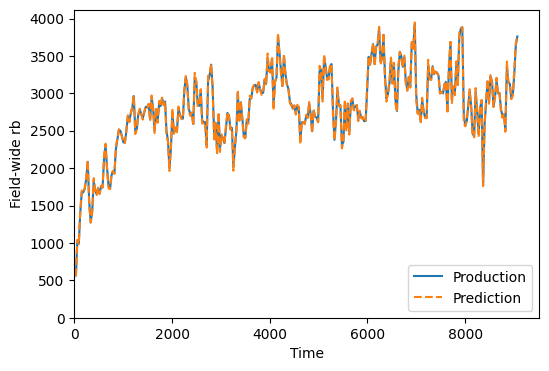

In [7]:
crm = CRM(primary=False, tau_selection="per-pair", constraints="up-to one")
crm.fit(prod.sum(axis=1).to_frame().values, inj.sum(axis=1).to_frame().values, time.values[:, 0])
q_hat = crm.predict()

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(time, prod.sum(axis=1), label="Production")
ax.plot(time, q_hat[:, 0], "--", label="Prediction")
ax.legend(loc="lower right")
ax.set(xlim=(0, None), ylim=(0, None), xlabel="Time", ylabel="Field-wide rb");

I'm not sure how useful this tank model is, but it's a good match.

With CRMP, you can simplify the analysis by assigning only one time constant for each producer:

In [8]:
crm = CRM(primary=False, tau_selection="per-producer", constraints="up-to one")
crm.fit(prod.values, inj.values, time.values[:, 0])
q_hat = crm.predict()

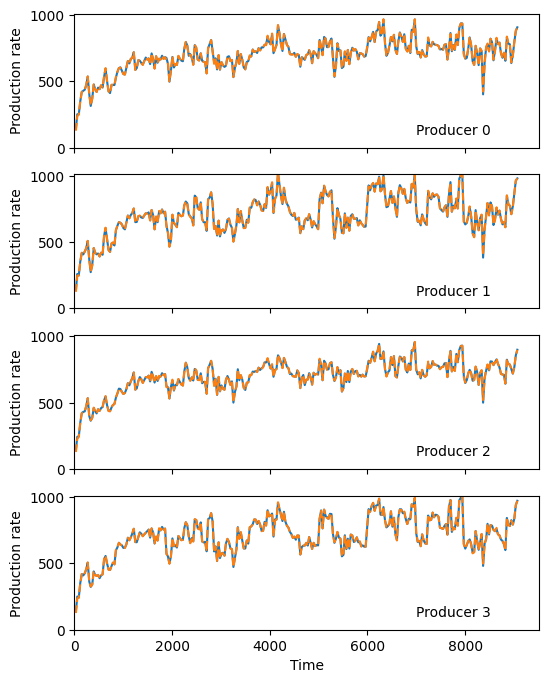

In [9]:
fig, axes = plt.subplots(len(prod.columns), figsize=(6, 8), sharex=True, sharey=True)
for i, p in enumerate(prod):
    axes[i].plot(time, prod[p], label="Production")
    axes[i].plot(time, q_hat[:, i], ls="--", label="Prediction")
    axes[i].set(xlim=(0, None), ylim=(0, None), ylabel="Production rate")
    axes[i].annotate(f"Producer {p}", xy=(7000, 100))
axes[i].set(xlabel="Time");

CRMP is much faster to fit than full CRMIP, but in many cases it is less accurate. Here, it seems to be doing quite well. CRM-Block is not yet implemented in `pywaterflood`, but it breaks the tank models between injectors and producers into blocks. This allows for production responses to injectors to be delayed. ML-CRM is the same as CRMIP, except it relies on production and injection data being measured at the perforation level.